In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from  matplotlib import font_manager, rc
from tqdm import trange
from torch.utils.data import DataLoader, Dataset
import random
# model을 import
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
import torch
from torch import nn
from torch import optim
from tqdm import tqdm

/media/sda1/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
font_list = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
person_info = pd.read_csv("../dataset/LPOINT_BIG_COMP_01_DEMO.csv", low_memory = False)
purchase_info = pd.read_csv("../dataset/LPOINT_BIG_COMP_02_PDDE.csv", low_memory = False)

In [3]:
purchase_info.loc[purchase_info['de_hr'] == 0, 'de_hr'] = '00'
purchase_info.loc[purchase_info['de_hr'] == 1, 'de_hr'] = '01'
purchase_info.loc[purchase_info['de_hr'] == 2, 'de_hr'] = '02'
purchase_info.loc[purchase_info['de_hr'] == 3, 'de_hr'] = '03'
purchase_info.loc[purchase_info['de_hr'] == 4, 'de_hr'] = '04'
purchase_info.loc[purchase_info['de_hr'] == 5, 'de_hr'] = '05'
purchase_info.loc[purchase_info['de_hr'] == 6, 'de_hr'] = '06'
purchase_info.loc[purchase_info['de_hr'] == 7, 'de_hr'] = '07'
purchase_info.loc[purchase_info['de_hr'] == 8, 'de_hr'] = '08'
purchase_info.loc[purchase_info['de_hr'] == 9, 'de_hr'] = '09'


In [4]:
purchase_info['de_dt'] = purchase_info['de_dt'].astype('str')
purchase_info['de_hr'] = purchase_info['de_hr'].astype('str')
purchase_info['time'] = purchase_info['de_dt'] + purchase_info['de_hr']

In [5]:
purchase_info['time'] = pd.to_datetime(purchase_info['time'].str.slice(start=0, stop=4) + "/" + purchase_info['time'].str.slice(start=4, stop=6) + "/" +purchase_info['time'].str.slice(start=6, stop=8) + "/" + purchase_info['time'].str.slice(start=8, stop=10) + ":0")

In [6]:
# person_info에 ma_fem_dv가 남성인 것만 추출
man_values = person_info.loc[person_info['ma_fem_dv'] == '남성']['cust'].values
man_purchase = purchase_info[purchase_info['cust'].isin(man_values)]

In [7]:
annual_purchase = man_purchase[['time','buy_ct']].groupby('time').sum()
annual_purchase.reset_index(inplace=True)

In [8]:
time_data = pd.date_range(start=annual_purchase.time.min(), end=annual_purchase.time.max(), freq='1H')
df_new = pd.merge(pd.DataFrame({'time': time_data}), annual_purchase, how='left', left_on='time', right_on='time').fillna(0).astype({'buy_ct': 'int64'})
df_new

,time,buy_ct
0,2021-01-01 00:00:00,23
1,2021-01-01 01:00:00,4
2,2021-01-01 02:00:00,7
3,2021-01-01 03:00:00,0
4,2021-01-01 04:00:00,8
...,...,...
8755,2021-12-31 19:00:00,488
8756,2021-12-31 20:00:00,461
8757,2021-12-31 21:00:00,355
8758,2021-12-31 22:00:00,225


In [9]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_new["buy_ct"] = min_max_scaler.fit_transform(df_new["buy_ct"].to_numpy().reshape(-1,1))

In [10]:
train = df_new[:-744]
train = train["buy_ct"].to_numpy()
print(train.shape)
test = df_new[-744:]
test = test["buy_ct"].to_numpy()
print(test.shape)

(8016,)
(744,)


In [11]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [12]:
iw = 1488
ow = 744

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

In [13]:
import torch.nn as nn
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden
    
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs
	
    # 편의성을 위해 예측해주는 함수도 생성한다.
    def predict(self, inputs, target_len):
        self.eval()
        inputs = inputs.unsqueeze(0)
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [14]:
import torch
from torch import optim
device = torch.device("cuda:1")
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [15]:
from tqdm import tqdm
loss_list = []
total_batch = len(train_loader)
model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        cost = 0
        train_loss = []
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
            cost += loss
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))
        avg_cost = cost / total_batch
        loss_list.append(avg_cost.detach().cpu().numpy())
        if i == epoch-1:
            torch.save(model.state_dict(), "./lstm.pth")
        

100%|██████████| 100/100 [1:19:31<00:00, 47.71s/it, loss=0.00373]


In [16]:
predict = model.predict(torch.tensor(train[-1488:]).reshape(-1,1).to(device).float(), target_len=ow)
real = df_new["buy_ct"].to_numpy()

predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

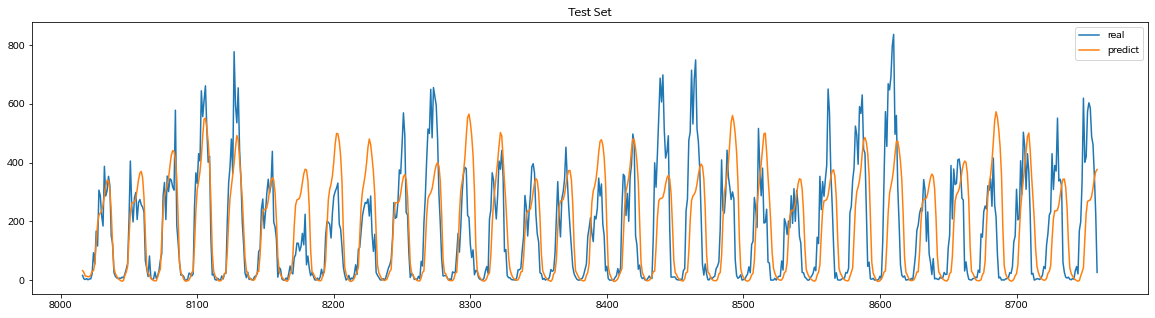

In [18]:
plt.figure(figsize=(20,5))
plt.plot(range(8016,8760), real[8016:], label="real")
plt.plot(range(8760-744,8760), predict[-744:], label="predict")

plt.title("Test Set")
plt.legend()
plt.show()